Example Profiling
==============================



Example using cProfile/pstats
-----------------------------

Following an example how to profile the algorithm using https://docs.python.org/3/library/profile.html


In [1]:
from __future__ import print_function

from HelperPackage import IPTestSuite
from HelperPackage import HelperClass

from HelperPackage.IPPerfMonitor import IPPerfMonitor

from BasicPRM import IPVISBasicPRM 
from BasicPRM import IPBasicPRM_Roundtrip

from VisibilityPRM import IPVisibilityPRM_Roundtrip
from VisibilityPRM import IPVISVisibilityPRM

from VisibilityPRM import CC_IPVisibilityPRM_Roundtrip

from LazyPRM import IPLazyPRM_Roundtrip
from LazyPRM import IPVISLazyPRM

from IPython.utils import io

from matplotlib import pylab as plt

benchList = IPTestSuite.benchList

start = benchList[0].startList

plannerFactory = dict()

basicConfig = dict()
basicConfig["radius"] = 3
basicConfig["numNodes"] = 200
plannerFactory["basePRM"] = [IPBasicPRM_Roundtrip.BasicPRM, basicConfig, IPVISBasicPRM.basicPRMVisualize]

visbilityConfig = dict()
visbilityConfig["ntry"] = 300
plannerFactory["visibilityPRM"] = [IPVisibilityPRM_Roundtrip.VisPRM, visbilityConfig, IPVISVisibilityPRM.visibilityPRMVisualize ]

lazyConfig = dict()
lazyConfig["initialRoadmapSize"] = 50
lazyConfig["updateRoadmapSize"]  = 2
lazyConfig["kNearest"] = 10
plannerFactory["lazyPRM"] = [IPLazyPRM_Roundtrip.LazyPRM, lazyConfig, IPVISLazyPRM.lazyPRMVisualize]

In [2]:
class ResultCollection (object):
    
    def __init__(self, plannerFactoryName, planner, benchmark, solution, perfDataFrame):
        self.plannerFactoryName = plannerFactoryName
        self.planner = planner
        self.benchmark = benchmark
        self.solution = solution
        self.perfDataFrame = perfDataFrame

In [3]:
resultList = list()
testList = benchList[:1]
i = 0
for key,producer in list(plannerFactory.items()):
    HelperClass.HelperClass.printInColor(str(key)+" "+ str(producer), 'yellow')
    print(key)
    for benchmark in testList:
        planner = producer[0](benchmark.collisionChecker)
        IPPerfMonitor.clearData()
        
        try:
            with io.capture_output() as captured:
                resultList.append(ResultCollection(key,
                                        planner, 
                                        benchmark, 
                                        planner.planRoundPath(benchmark.startList,benchmark.interimGoalList,producer[1]),
                                        IPPerfMonitor.dataFrame()),)
            i = i + 1

        except Exception as e:
            HelperClass.HelperClass.printInColor("PLANNING ERROR ! PLANNING ERROR ! PLANNING ERROR", 'red')
            HelperClass.HelperClass.printInColor(e, 'red')
            pass

        

basePRM


visibilityPRM


lazyPRM


In [4]:
# Executing the planning. 
import cProfile
from HelperPackage.IPPRMBase import PRMBase

plannerBasic = resultList[0].planner
plannerBasicProducer = plannerFactory["basePRM"]
plannerVisibility = resultList[1].planner
plannerVisibilityProducer = plannerFactory["visibilityPRM"]
plannerLazy = resultList[2].planner
plannerLazyProducer = plannerFactory["lazyPRM"]

HelperClass.HelperClass.printInColor("BasicPRMRound", "orange")
with io.capture_output() as capturedBasic:
    cProfile.run('solution =plannerBasic.planRoundPath(benchList[0].startList,benchList[0].interimGoalList,plannerBasicProducer[1])','./stats/basicstats') 

HelperClass.HelperClass.printInColor("VisibiltyPRMRound", "orange")
with io.capture_output() as capturedVisibility:
    cProfile.run('solution = plannerVisibility.planRoundPath(benchList[0].startList,benchList[0].interimGoalList,plannerVisibilityProducer[1])','./stats/visibilitystats') 

HelperClass.HelperClass.printInColor("LazyPRMRound", "orange")
with io.capture_output() as capturedVisibility:
    cProfile.run('solution = plannerLazy.planRoundPath(benchList[0].startList,benchList[0].interimGoalList,plannerLazyProducer[1])','./stats/lazystats')

In [5]:
# utility functions to read and access data in astartstats
import pstats
from pstats import SortKey

p = pstats.Stats('./stats/basicstats')
p.strip_dirs().sort_stats(SortKey.CALLS).print_stats()
p.sort_stats(SortKey.CUMULATIVE).print_stats(15)
p.sort_stats(SortKey.CALLS).print_stats(15)
p.sort_stats(SortKey.TIME).print_stats(15)

for bench, result in zip(testList, resultList):
    title = bench.name
    pathLength = dict()
    planningTime = dict()
    roadmapSize  = dict()
    
    if result.benchmark.name == bench.name:
        pathLength[result.plannerFactoryName] = len(result.solution)
        planningTime[result.plannerFactoryName] = result.perfDataFrame.groupby(["name"]).sum(numeric_only=True)["time"]["planRoundPath"]
        roadmapSize[result.plannerFactoryName] = result.planner.graph.size()



Mon Jan 22 15:18:21 2024    ./stats/basicstats

         1135248 function calls (1124803 primitive calls) in 0.682 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   189250    0.012    0.000    0.012    0.000 {built-in method builtins.len}
   159250    0.011    0.000    0.011    0.000 {method 'append' of 'list' objects}
   142824    0.011    0.000    0.011    0.000 {method 'add' of 'set' objects}
    67592    0.032    0.000    0.032    0.000 base.py:245(__setattr__)
    64613    0.024    0.000    0.024    0.000 {built-in method numpy.asarray}
    43042    0.014    0.000    0.036    0.000 distance.py:313(_validate_vector)
    33796    0.004    0.000    0.004    0.000 base.py:228(_geom)
    21677    0.003    0.000    0.003    0.000 {method 'get' of 'dict' objects}
    21521    0.024    0.000    0.066    0.000 function_base.py:564(asarray_chkfinite)
    21521    0.030    0.000    0.168    0.000 distance.py:429(minkowski)
    2152

In [6]:
# utility functions to read and access data in astartstats
import pstats
from pstats import SortKey

p = pstats.Stats('./stats/visibilitystats')
p.strip_dirs().sort_stats(SortKey.CALLS).print_stats()
p.sort_stats(SortKey.CUMULATIVE).print_stats(15)
p.sort_stats(SortKey.CALLS).print_stats(15)
p.sort_stats(SortKey.TIME).print_stats(15)


for bench, result in zip(testList, resultList):
    title = bench.name
    pathLength = dict()
    planningTime = dict()
    roadmapSize  = dict()
    if result.benchmark.name == bench.name:
        pathLength[result.plannerFactoryName] = len(result.solution)
        planningTime[result.plannerFactoryName] = result.perfDataFrame.groupby(["name"]).sum(numeric_only=True)["time"]["planRoundPath"]
        roadmapSize[result.plannerFactoryName] = result.planner.graph.size()


Mon Jan 22 15:18:22 2024    ./stats/visibilitystats

         1222380 function calls (1192308 primitive calls) in 1.015 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   227440    0.108    0.000    0.108    0.000 base.py:245(__setattr__)
   148662    0.011    0.000    0.011    0.000 {built-in method builtins.len}
   113720    0.014    0.000    0.014    0.000 base.py:228(_geom)
    60134    0.006    0.000    0.006    0.000 {built-in method time.time}
    59892    0.007    0.000    0.007    0.000 {built-in method builtins.isinstance}
    56873    0.008    0.000    0.008    0.000 {built-in method builtins.hasattr}
    56860    0.058    0.000    0.115    0.000 base.py:191(_empty)
    56860    0.025    0.000    0.036    0.000 topology.py:18(_validate)
    34013    0.003    0.000    0.003    0.000 {method 'append' of 'list' objects}
    30636    0.003    0.000    0.003    0.000 IPEnvironment.py:23(getDim)
    30067    0.038    0.00

In [7]:
# utility functions to read and access data in astartstats
import pstats
from pstats import SortKey

p = pstats.Stats('./stats/lazystats')
p.strip_dirs().sort_stats(SortKey.CALLS).print_stats()
p.sort_stats(SortKey.CUMULATIVE).print_stats(15)
p.sort_stats(SortKey.CALLS).print_stats(15)
p.sort_stats(SortKey.TIME).print_stats(15)

for bench, result in zip(testList, resultList):
    title = bench.name
    pathLength = dict()
    planningTime = dict()
    roadmapSize  = dict()
    
    if result.benchmark.name == bench.name:
        pathLength[result.plannerFactoryName] = len(result.solution)
        planningTime[result.plannerFactoryName] = result.perfDataFrame.groupby(["name"]).sum(numeric_only=True)["time"]["planRoundPath"]
        roadmapSize[result.plannerFactoryName] = result.planner.graph.size()


Mon Jan 22 15:18:22 2024    ./stats/lazystats

         60672 function calls (59623 primitive calls) in 0.052 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     7232    0.003    0.000    0.003    0.000 base.py:245(__setattr__)
     4816    0.000    0.000    0.000    0.000 {built-in method builtins.len}
     3758    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
     3616    0.000    0.000    0.000    0.000 base.py:228(_geom)
     2200    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
     2087    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
     2030    0.000    0.000    0.000    0.000 {built-in method time.time}
     1821    0.001    0.000    0.001    0.000 reportviews.py:188(__getitem__)
     1821    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
     1808    0.002    0.000    0.004    0.000 base.py:191(_empty)
     1808    0.001    0

Example using IPerfMonitor
--------------------------

In [8]:
from HelperPackage.IPPerfMonitor import IPPerfMonitor

In [9]:
benchList = IPTestSuite.benchList

with io.capture_output() as captured:
    solution = planner.planRoundPath(benchList[0].startList,benchList[0].interimGoalList,producer[1])


start = benchList[0].startList

data_frame = IPPerfMonitor.dataFrame()


In [10]:
resultList = list()
testList = benchList[:1]

solution = list()
data_frame = list()
i = 0
for key,producer in list(plannerFactory.items()):
    HelperClass.HelperClass.printInColor(str(key)+" "+ str(producer), 'yellow')

    for benchmark in testList:

        planner = producer[0](benchmark.collisionChecker)
        IPPerfMonitor.clearData()
        
        try:
            with io.capture_output() as captured:

                solution.append(planner.planRoundPath(benchList[0].startList,benchList[0].interimGoalList,producer[1]))
                data_frame.append(IPPerfMonitor.dataFrame())

                i = i + 1


        except Exception as e:
            HelperClass.HelperClass.printInColor("PLANNING ERROR ! PLANNING ERROR ! PLANNING ERROR", 'red')
            HelperClass.HelperClass.printInColor(e, 'red')
            pass

In [11]:
HelperClass.HelperClass.printInColor("Basic", "orange")
print(data_frame[0].groupby(["name"]).sum(numeric_only=True))
print("")

HelperClass.HelperClass.printInColor("Visibility", "orange")
print(data_frame[1].groupby(["name"]).sum(numeric_only=True))
print("")

HelperClass.HelperClass.printInColor("Lazy", "orange")
print(data_frame[2].groupby(["name"]).sum(numeric_only=True))

                                   time
name                                   
_getRandomFreePosition         0.011006
_inSameConnectedComponent      0.033024
_learnRoadmapNearestNeighbour  0.265322
_nearestInterim                0.002996
_nearestNeighbours             0.099094
lineInCollision                0.129029
planRoundPath                  0.280158
pointInCollision               0.103995



                               time
name                               
_checkConnectableInterims  0.008183
_getRandomFreePosition     0.007000
_learnRoadmap              0.259022
_nearestInterim            0.001007
lineInCollision            0.256207
planRoundPath              0.268212
pointInCollision           0.196219



                                 time
name                                 
_buildRoadmap                0.008279
_checkForCollisionAndUpdate  0.023878
_nearestInterim              0.003008
lineInCollision              0.021370
planRoundPath                0.039172
pointInCollision             0.016882


In [12]:
HelperClass.HelperClass.printInColor("Basic", "orange")
print(data_frame[0][data_frame[0]["name"]=="pointInCollision"][data_frame[0]["retVal"]==True].count())

HelperClass.HelperClass.printInColor("Visibility", "orange")
print(data_frame[1][data_frame[1]["name"]=="pointInCollision"][data_frame[1]["retVal"]==True].count())

HelperClass.HelperClass.printInColor("Lazy", "orange")
print(data_frame[2][data_frame[2]["name"]=="pointInCollision"][data_frame[2]["retVal"]==True].count())


name      37
args      37
kwargs    37
retVal    37
time      37
dtype: int64


C:\Users\andre\AppData\Local\Temp\ipykernel_23800\3808455586.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(data_frame[0][data_frame[0]["name"]=="pointInCollision"][data_frame[0]["retVal"]==True].count())


name      387
args      387
kwargs    387
retVal    387
time      387
dtype: int64


C:\Users\andre\AppData\Local\Temp\ipykernel_23800\3808455586.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(data_frame[1][data_frame[1]["name"]=="pointInCollision"][data_frame[1]["retVal"]==True].count())


name      32
args      32
kwargs    32
retVal    32
time      32
dtype: int64


C:\Users\andre\AppData\Local\Temp\ipykernel_23800\3808455586.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(data_frame[2][data_frame[2]["name"]=="pointInCollision"][data_frame[2]["retVal"]==True].count())


In [13]:
HelperClass.HelperClass.printInColor("Basic", "orange")
print(data_frame[0].groupby(["name"]).count())
print("")
HelperClass.HelperClass.printInColor("Visibility", "orange")
print(data_frame[1].groupby(["name"]).count())
print("")
HelperClass.HelperClass.printInColor("Lazy", "orange")
print(data_frame[2].groupby(["name"]).count())



                               args  kwargs  retVal  time
name                                                     
_getRandomFreePosition          200     200     200   200
_inSameConnectedComponent      1270    1270    1270  1270
_learnRoadmapNearestNeighbour     1       1       0     1
_nearestInterim                  39      39      39    39
_nearestNeighbours              206     206     206   206
lineInCollision                 206     206     206   206
planRoundPath                     1       1       1     1
pointInCollision               8451    8451    8451  8451



                            args  kwargs  retVal   time
name                                                   
_checkConnectableInterims      1       1       0      1
_getRandomFreePosition       300     300     300    300
_learnRoadmap                  1       1       0      1
_nearestInterim               12      12      12     12
lineInCollision              653     653     653    653
planRoundPath                  1       1       1      1
pointInCollision           16880   16880   16880  16880



                             args  kwargs  retVal  time
name                                                   
_buildRoadmap                  33      33       0    33
_checkForCollisionAndUpdate    52      52      52    52
_nearestInterim                25      25      25    25
lineInCollision                42      42      42    42
planRoundPath                   1       1       1     1
pointInCollision             1191    1191    1191  1191


Second Example using IPPerfMonitor
----------------------------------

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


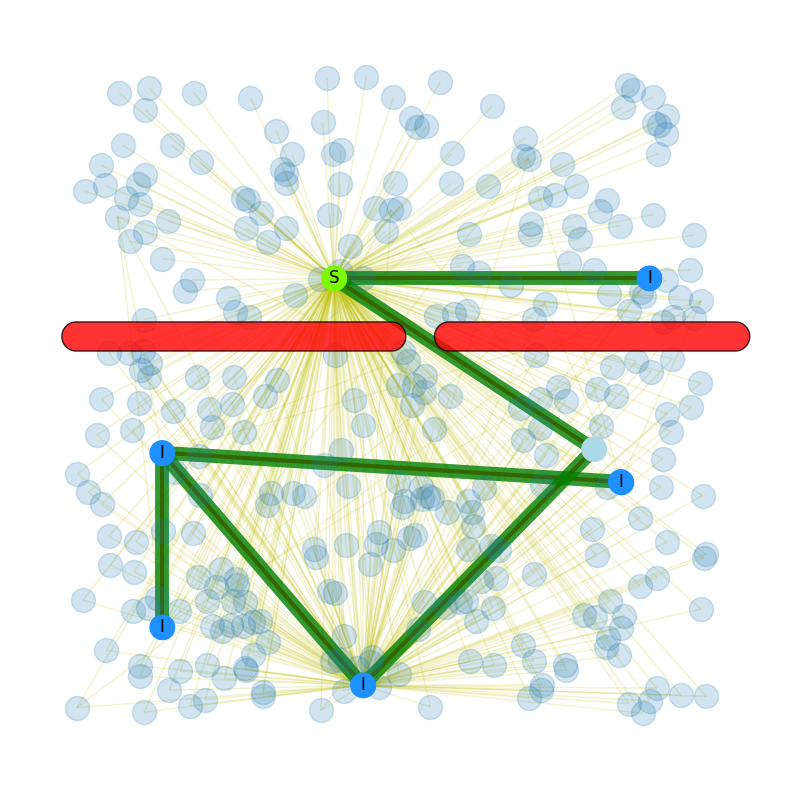

In [14]:
visbilityConfig = dict()
visbilityConfig["ntry"] = 300

vis = plannerFactory["visibilityPRM"][0](benchList[1].collisionChecker)

start = benchList[1].startList

IPPerfMonitor.clearData()

with io.capture_output() as captured:
    solution = vis.planRoundPath(benchmark.startList,benchmark.interimGoalList,visbilityConfig)

data_frame = IPPerfMonitor.dataFrame()

fig_local = plt.figure(figsize=(10,10))
ax = fig_local.add_subplot(1,1,1)
IPVISVisibilityPRM.visibilityPRMVisualize(vis, solution, ax = ax)

In [15]:
data_frame

,name,args,kwargs,retVal,time
0,pointInCollision,(<HelperPackage.IPEnvironment.CollisionChecker...,{},False,0.000000
1,pointInCollision,(<HelperPackage.IPEnvironment.CollisionChecker...,{},False,0.000000
2,pointInCollision,(<HelperPackage.IPEnvironment.CollisionChecker...,{},False,0.000000
3,pointInCollision,(<HelperPackage.IPEnvironment.CollisionChecker...,{},False,0.000000
4,pointInCollision,(<HelperPackage.IPEnvironment.CollisionChecker...,{},False,0.000000
...,...,...,...,...,...
18856,_nearestInterim,(<VisibilityPRM.IPVisibilityPRM_Roundtrip.VisP...,{},"[[20, 15], 11.0, interim3]",0.000000
18857,_nearestInterim,(<VisibilityPRM.IPVisibilityPRM_Roundtrip.VisP...,{},"[[20, 15], 0.0, interim3]",0.000000
18858,_checkConnectableInterims,(<VisibilityPRM.IPVisibilityPRM_Roundtrip.VisP...,{},None,0.009999
18859,_learnRoadmap,(<VisibilityPRM.IPVisibilityPRM_Roundtrip.VisP...,{},None,0.486255


In [16]:
data_frame.groupby(["name"]).count()

,args,kwargs,retVal,time
name,,,,
_checkConnectableInterims,1,1,0,1
_getRandomFreePosition,300,300,300,300
_learnRoadmap,1,1,0,1
_nearestInterim,17,17,17,17
lineInCollision,528,528,528,528
planRoundPath,1,1,1,1
pointInCollision,18013,18013,18013,18013


In [17]:
data_frame.groupby(["name"]).sum(numeric_only=True)

,time
name,
_checkConnectableInterims,0.009999
_getRandomFreePosition,0.008512
_learnRoadmap,0.486255
_nearestInterim,0.000000
lineInCollision,0.481227
planRoundPath,0.497256
pointInCollision,0.420910
